In [31]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np


In [32]:
x, y = make_moons(n_samples = 1000, noise = 0.05, random_state = 42)

print(x[:10], y[:10])

[[-0.02137124  0.40618608]
 [ 0.97670045 -0.45832306]
 [ 0.90405882 -0.37651952]
 [ 0.37736316 -0.39703717]
 [-0.84192557  0.53058695]
 [ 0.58930337 -0.32137599]
 [ 0.29248724 -0.20696309]
 [-0.02637836  0.44766267]
 [ 1.6201408  -0.28758856]
 [ 0.68246733  0.80712069]] [1 1 1 1 0 1 1 1 1 0]


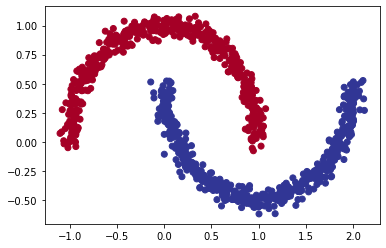

In [33]:
plt.scatter(x[:,0], x[:,1], c=y, cmap=plt.cm.RdYlBu)

In [34]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [35]:
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

x_train, x_test, y_train, y_test = train_test_split(x ,y , test_size = 0.25, random_state = 42)

x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

In [67]:
class Moonmodel(nn.Module):
  def __init__(self, input_features, output_features, hidden_features):
    super().__init__()

    self.network = nn.Sequential(
        nn.Linear(in_features = input_features, out_features = hidden_features),
        nn.ReLU(),
        nn.Linear(in_features = hidden_features, out_features = hidden_features),
        nn.ReLU(),
        nn.Linear(in_features = hidden_features, out_features = output_features)
    )

  def forward(self, x):
    return self.network(x)

model_moon = Moonmodel(input_features = 2, output_features = 1, hidden_features = 8).to(device)
model_moon

Moonmodel(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [68]:
# loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = model_moon.parameters(), lr = 0.25)

In [69]:
# def accuracy_fn(y_true, y_pred):
#   correct = torch.eq(y_true, y_pred).sum().item()
#   acc = (correct/len(y_pred)) * 100
#   return acc

!pip -q install torchmetrics

In [70]:
from torchmetrics import Accuracy

torchmetrics_acc = Accuracy(task = 'binary', num_classes = 2).to(device)

In [71]:
# training loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epoches = 500

for epoch in range(epoches):
  # train
  model_moon.train()
  # 1.Forward
  y_logits = model_moon(x_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2.Loss
  loss = loss_fn(y_logits, y_train)
  acc = torchmetrics_acc(y_pred, y_train)

  # 3. Grad zero
  optimizer.zero_grad()

  # 4. Backward
  loss.backward()

  # 5. grad step
  optimizer.step()

  # test
  model_moon.eval()
  with torch.inference_mode():
    # 1. Forward
    test_logits = model_moon(x_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = torchmetrics_acc(test_pred, y_test)

  if epoch % 50 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss} | acc: {acc} | test_acc: {test_acc}")

Epoch: 0 | Loss: 0.7125279307365417 | Test Loss: 0.700917661190033 | acc: 0.4946666657924652 | test_acc: 0.515999972820282
Epoch: 50 | Loss: 0.3122707009315491 | Test Loss: 0.28622183203697205 | acc: 0.8533333539962769 | test_acc: 0.871999979019165
Epoch: 100 | Loss: 0.2378358542919159 | Test Loss: 0.2018153816461563 | acc: 0.8853333592414856 | test_acc: 0.9160000085830688
Epoch: 150 | Loss: 0.2141002118587494 | Test Loss: 0.17836399376392365 | acc: 0.8986666798591614 | test_acc: 0.9240000247955322
Epoch: 200 | Loss: 0.17378224432468414 | Test Loss: 0.14276766777038574 | acc: 0.9240000247955322 | test_acc: 0.9440000057220459
Epoch: 250 | Loss: 0.11536409705877304 | Test Loss: 0.09311560541391373 | acc: 0.9506666660308838 | test_acc: 0.9800000190734863
Epoch: 300 | Loss: 0.06564366817474365 | Test Loss: 0.052056945860385895 | acc: 0.9893333315849304 | test_acc: 0.9959999918937683
Epoch: 350 | Loss: 0.03871868923306465 | Test Loss: 0.030204487964510918 | acc: 0.9959999918937683 | test_ac

In [72]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("file exists, skip download")
else:
  print("Download file")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

file exists, skip download


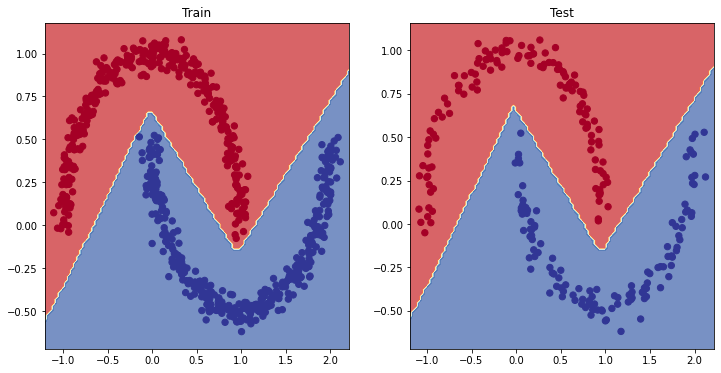

In [73]:
# plot decision boundary of model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_moon, x_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_moon, x_test, y_test)

In [81]:
# save and load model
from pathlib import Path

FOLDER = Path("models")
FOLDER.mkdir(parents = True, exist_ok = True)

FILE_NAME = 'Binary_classification.pth'
FILE_SAVE = FOLDER / FILE_NAME

torch.save(obj = model_moon.state_dict(), f = FILE_SAVE)

In [86]:
# load
model_moon_load = Moonmodel(2, 1, 8)

model_moon_load.load_state_dict(torch.load(f = FILE_SAVE))

model_moon_load

Moonmodel(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [87]:
model_moon_load = model_moon_load.to(device)

In [88]:
with torch.inference_mode():
  load_logits = model_moon_load(x_test).squeeze()
  load_pred = torch.round(torch.sigmoid(load_logits))

load_pred == test_pred

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

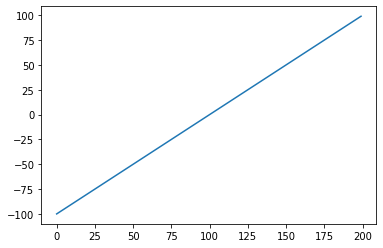

In [76]:
# raplicate thanh
torch_a = torch.arange(-100, 100, 1)
plt.plot(torch_a)

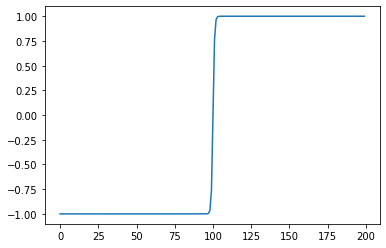

In [77]:
plt.plot(torch.tanh(torch_a))

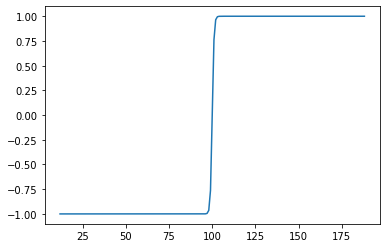

In [79]:
def tanh(x):
  return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

plt.plot(tanh(torch_a))